## Importing the files and doing bare minimum addn'l prep to them

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('../../data/X_train',index_col= 0)
y_train = pd.read_csv('../../data/y_train', index_col =0)
X_test = pd.read_csv('../../data/X_test', index_col = 0)
y_test = pd.read_csv('../../data/y_test', index_col = 0)

In [4]:
def remove_unsure(score):
    if score == 3:
        return 1
    else: 
        return score

In [5]:
y_test['emotion'] = y_test['emotion'].apply(lambda x: remove_unsure(x))

In [6]:
y_train['emotion'] = y_train['emotion'].apply(lambda x: remove_unsure(x))

In [7]:
X_train[X_train.isna().any(axis=1)]


,cleaned_tweets
6,NaN
7346,NaN


In [8]:
y_train = y_train.drop(index=[6,7346])


In [9]:
X_train.dropna(inplace= True)

In [10]:
X_train.isna().sum()

cleaned_tweets    0
dtype: int64

In [11]:
X_train.shape, y_train.shape

((6363, 1), (6363, 1))

In [12]:
X_test.isna().sum()

cleaned_tweets    0
dtype: int64

In [13]:
X_test.shape, y_test.shape

((7274, 1), (7274, 1))

### Vectorize DFs


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vec = TfidfVectorizer()

In [16]:
X_tr_tfidf = tfidf_vec.fit_transform(X_train['cleaned_tweets'])
X_te_tfidf = tfidf_vec.transform(X_test['cleaned_tweets'])

In [17]:

X_tr_tfidf_df = pd.DataFrame(X_tr_tfidf.toarray(), 
                              columns=tfidf_vec.get_feature_names(), 
                              index=X_train.index)

In [18]:
X_te_tfidf_df = pd.DataFrame(X_te_tfidf.toarray(),
                            columns = tfidf_vec.get_feature_names(),
                            index= X_test.index)

## Dimensionality Reduction 

While we have generally looked to PCA as the primary means of dimensionality reduction the Scikit-learn documentation recommends using truncated singular value decomposition - per the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)(emphasis mine): 



"This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. **This means it can work with sparse matrices efficiently.**

**In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).**"



In [19]:
from sklearn.decomposition import TruncatedSVD

In [39]:
# reducing dimensionality using 100 n_components per sklearn documentation
# recommendation for LSA (latent semantic analysis)
svd = TruncatedSVD(n_components=100, n_iter=10)
svd.fit(X_tr_tfidf_df)
X_tr_tfidf_SVD = svd.transform(X_tr_tfidf_df)

In [40]:
# checking to make sure shape is as expected 
X_tr_tfidf_SVD.shape

(6363, 100)

## KMeans model

In [30]:
from sklearn.cluster import KMeans

In [41]:
# setting clusters to three as that is the number of desired for this 
# dataset - positive, negative, neutral

k_means = KMeans(n_clusters=3).fit(X_tr_tfidf_SVD)

# capturing predicted labels 
predicted_clusters = k_means.labels_

In [42]:
predicted_clusters

array([2, 2, 2, ..., 2, 1, 2])

In [43]:
# finding cluster centers
centers = k_means.cluster_centers_

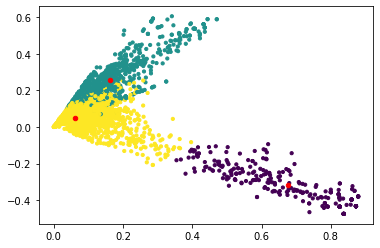

In [44]:
#plotting predicted clusters, cluster centers are larger red dots 

plt.scatter(X_tr_tfidf_SVD[:, 0], X_tr_tfidf_SVD[:, 1], c=predicted_clusters, s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='r', s=20)

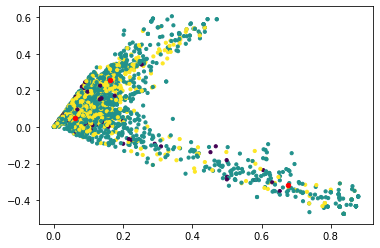

In [45]:
# plotting actual cluster target values, cluster centers from 
# predictions retained as larger red dots

plt.scatter(X_tr_tfidf_SVD[:, 0], X_tr_tfidf_SVD[:, 1], c=y_train['emotion'], s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='r', s=20)

# Scores 

In [82]:
from sklearn.metrics import calinski_harabasz_score

In [93]:
k_means_2 = KMeans(n_clusters=2).fit(X_tr_tfidf_SVD)
k_means_3 = KMeans(n_clusters=3).fit(X_tr_tfidf_SVD)
k_means_4 = KMeans(n_clusters=10).fit(X_tr_tfidf_SVD)
k_means_5 = KMeans(n_clusters=25).fit(X_tr_tfidf_SVD)
k_means_6 = KMeans(n_clusters=50).fit(X_tr_tfidf_SVD)
k_means_7 = KMeans(n_clusters=60).fit(X_tr_tfidf_SVD)


k_list = [k_means_2, k_means_3,k_means_4,k_means_5,k_means_6, k_means_7]

In [94]:
CH_score = [calinski_harabasz_score(X_tr_tfidf_SVD,k.labels_) for k in k_list]

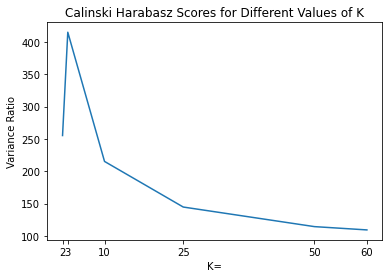

In [96]:
plt.plot([2,3, 10, 25, 50, 60], CH_score)
plt.xticks([2,3, 10, 25, 50, 60])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [98]:
wcss_score = []

In [99]:
wcss_score = [k.inertia_ for k in k_list]

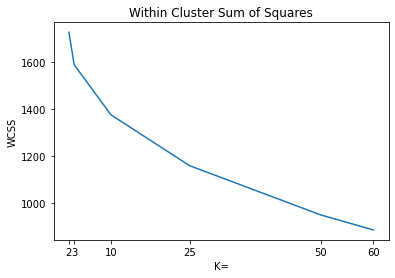

In [101]:
plt.plot([2,3, 10, 25, 50, 60], wcss_score)
plt.xticks([2,3, 10, 25, 50, 60])

plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [103]:
from sklearn.metrics import silhouette_score

In [104]:
# Generate silhouette coefficient for each k
X = X_tr_tfidf_SVD
silhouette_plot = []
for k in [2,3, 10, 25, 50, 60]:
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

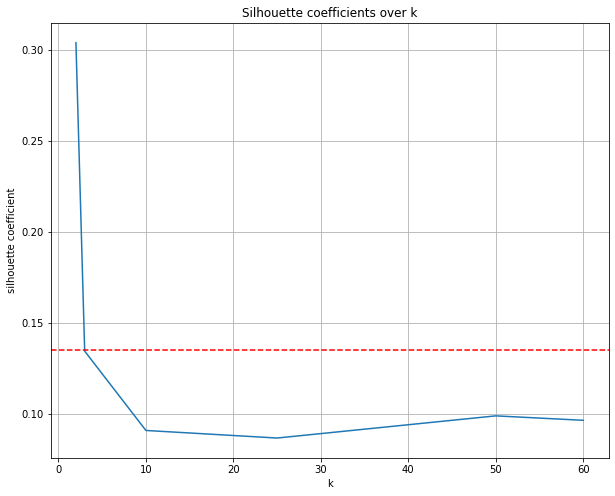

In [106]:
# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot([2,3, 10, 25, 50, 60], silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)